In [1]:
import os
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import operator 
import pandas as pd
import string
import re
import numpy as np
import sys
import os
import requests
import nltk
import pickle
init_notebook_mode(connected=True)
from gensim import corpora, models, similarities
import numpy as np
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [2]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array


In [3]:
df = pd.read_csv('combined_raw.txt', names=['text'])

In [4]:
df = df.dropna()

In [5]:
df.describe()

,text
count,1417
unique,1379
top,TCF7L2 Expression Is Regulated by Cell Differe...
freq,2


In [6]:
def strip_all_entities(text):
    
    entity_prefixes = ['_', ')','(', '[', ']']
    for separator in string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)

    return ' '.join(words)

def remove_stop_words(text):
    
    punctuation = set(string.punctuation)
    numbers = set(string.digits)
    stop_words = set(stopwords.words('english')) 
    words = []
    for word in text.split():
        if word not in (stop_words or punctuation or numbers):
            words.append(word.lower())
            
    return ' '.join(words)

def remove_numbers(text):
    words = []
    for word in text.split():
        if word.isalpha() == True:
            words.append(word)
        else:
            continue
    
    return ' '.join(words)


def lemmatize_words(text):
    
    from nltk import pos_tag
    wnl = WordNetLemmatizer()
    words = []
    for word in word_tokenize(text):
        if wnl.lemmatize(word, 'v') != word:
            words.append(wnl.lemmatize(word, 'v')) #verb
        elif wnl.lemmatize(word, 'n') != word:
            words.append(wnl.lemmatize(word, 'n')) #noun
        elif wnl.lemmatize(word, 'a') != word:
             words.append(wnl.lemmatize(word, 'a')) #adjective
        elif wnl.lemmatize(word, 'r') != word:
            words.append(wnl.lemmatize(word, 'r')) #adverb
        else:
            words.append(word) 
    
    return ' '.join(words)


df['text'] = df['text'].apply(lemmatize_words)
df['text'] = df['text'].apply(strip_all_entities)
df['text'] = df['text'].apply(remove_stop_words)
df['text'] = df['text'].apply(remove_numbers)
df['text'] = df['text'].apply(lemmatize_words)


In [7]:
df.text[1]

'a calpain gene polymorphism associate reduce muscle mrna level insulin resistance previous linkage study mexican american localize major susceptibility locus type diabetes chromosome this evidence linkage type diabetes recently find associate common g gt a polymorphism ucsnp within gene the risk genotype homozygous ucsnp g allele in present study among pima indian ucsnp g g genotype associate increase prevalence type diabetes however pima indian normal glucose tolerance g g genotype ucsnp find decrease rat postabsorptive insulin stimulate glucose turnover appear result decrease rat glucose oxidation in addition g g homozygote find reduce mrna expression skeletal muscle a decrease rate insulin mediate glucose turnover insulin resistance one mechanism polymorphism may increase susceptibility type diabetes mellitus old person'

In [8]:
#datalist = [i for i in df.text]
non_essential_words = ['b', 'p', 'tt', 'c', 'cc', 'ct', 'l', 'b', 'two', 'ci', 'ir', 'pcos', 'han', 'non']
stoplist = stopwords.words('english') + list(string.punctuation) + non_essential_words
texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in df.text]

In [9]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [10]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [11]:
model_list = []
coherence_scores = []
def tabulate_coherence(num_topics):
    
    num_topics = num_topics
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, passes=20)
    model_list.append(lda)
    coherence_model_lda_cv = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda_cv = coherence_model_lda_cv.get_coherence()
    coherence_scores.append(coherence_lda_cv)
    
for i in range(1, 200, 1):
    tabulate_coherence(i)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


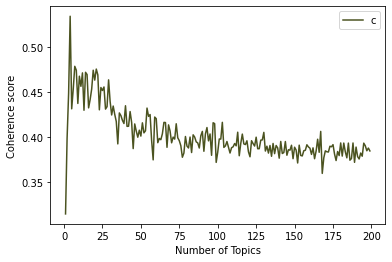

In [12]:
import matplotlib.pyplot as plt
limit=200; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_scores,color="#4b5320")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [13]:
max(coherence_scores), coherence_scores.index(max(coherence_scores))

(0.5341850819621329, 3)

In [30]:
total_topics = 4
lda = model_list[3]
corpus_lda = lda[corpus_tfidf]

In [31]:
coherence_model_lda_cv = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda_cv = coherence_model_lda_cv.get_coherence()
print('\nCoherence Score: ', coherence_lda_cv)


Coherence Score:  0.5341850819621329


In [32]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}

In [33]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

,age,allele,alpha,analysis,associate,association,beta,case,cause,cell,...,study,subject,susceptibility,test,transcription,type,use,variant,wnt,young
0,0.000000,0.008937,0.000000,0.00514,0.016398,0.019844,0.00000,0.005278,0.00000,0.000000,...,0.017283,0.00000,0.005853,0.000000,0.00000,0.015482,0.00000,0.012551,0.000000,0.000000
1,0.006028,0.000000,0.006854,0.00000,0.000000,0.000000,0.00000,0.000000,0.00759,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.009916,0.00000,0.000000,0.000000,0.012464
2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.01191,0.000000,0.00000,0.026357,...,0.000000,0.00000,0.000000,0.000000,0.00596,0.008619,0.00000,0.000000,0.006311,0.000000
3,0.004767,0.009350,0.000000,0.00000,0.012128,0.012279,0.00000,0.000000,0.00000,0.000000,...,0.016288,0.00747,0.000000,0.005586,0.00000,0.024256,0.00523,0.012048,0.000000,0.000000


In [34]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.045815 -0.174984       1        1  33.859081
0      0.116501  0.068029       2        1  26.575884
3      0.093015  0.006101       3        1  26.444847
2     -0.163700  0.100854       4        1  13.120188, topic_info=     Category       Freq           Term      Total  loglift  logprob
699   Default  18.000000       mutation  18.000000  30.0000  30.0000
271   Default  16.000000           mody  16.000000  29.0000  29.0000
192   Default   6.000000           cell   6.000000  28.0000  28.0000
1427  Default   9.000000            hnf   9.000000  27.0000  27.0000
31    Default  11.000000        insulin  11.000000  26.0000  26.0000
275   Default   9.000000          onset   9.000000  25.0000  25.0000
170   Default   9.000000            snp   9.000000  24.0000  24.0000
5     Default  12.000000    association  12.000000  23.0000  23.0000
69    Default   7.000000        glucose   7.000000  22.0000  22.0000
101   Default  14.000000           risk  14.000000  21.0000  21.0000
66    Default   3.000000     expression   3.000000  20.0000  20.0000
300   Default   6.000000          young   6.000000  19.0000  19.0000
188   Default   4.000000           beta   4.000000  18.0000  18.0000
268   Default   4.000000       maturity   4.000000  17.0000  17.0000
227   Default   3.000000      secretion   3.000000  16.0000  16.0000
1147  Default   4.000000        nuclear   4.000000  15.0000  15.0000
532   Default  14.000000        patient  14.000000  14.0000  14.0000
78    Default   4.000000          locus   4.000000  13.0000  13.0000
45    Default   8.000000     population   8.000000  12.0000  12.0000
209   Default   2.000000          islet   2.000000  11.0000  11.0000
911   Default   2.000000            gdm   2.000000  10.0000  10.0000
1144  Default   4.000000     hepatocyte   4.000000   9.0000   9.0000
90    Default   8.000000   polymorphism   8.000000   8.0000   8.0000
4     Default  12.000000      associate  12.000000   7.0000   7.0000
218   Default   2.000000     pancreatic   2.000000   6.0000   6.0000
61    Default   7.000000         allele   7.000000   5.0000   5.0000
200   Default   3.000000       function   3.000000   4.0000   4.0000
24    Default   6.000000         family   6.000000   3.0000   3.0000
1141  Default   3.000000          alpha   3.000000   2.0000   2.0000
258   Default   2.000000          human   2.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
209    Topic4   1.698070          islet   2.347078   1.7073  -4.6958
227    Topic4   2.133665      secretion   3.042663   1.6761  -4.4674
294    Topic4   0.800137         tissue   1.037831   1.7709  -5.4483
161    Topic4   0.541156     regulation   0.697893   1.7767  -5.8393
796    Topic4   1.179435         signal   1.742663   1.6406  -5.0602
258    Topic4   1.324821          human   2.011441   1.6134  -4.9440
44     Topic4   1.048781        pathway   1.599018   1.6093  -5.1777
69     Topic4   3.569128        glucose   7.087285   1.3450  -3.9530
188    Topic4   2.214189           beta   4.232819   1.3830  -4.4304
31     Topic4   4.522992        insulin  11.004488   1.1419  -3.7161
218    Topic4   1.492678     pancreatic   2.676062   1.4472  -4.8247
200    Topic4   1.583269       function   3.021166   1.3849  -4.7658
226    Topic4   0.942140       response   1.678581   1.4535  -5.2849
529    Topic4   0.657223     metabolism   1.020845   1.5907  -5.6450
64     Topic4   0.751166       decrease   1.286880   1.4927  -5.5114
737    Topic4   0.649103          liver   1.095247   1.5079  -5.6574
80     Topic4   0.844060      mechanism   1.650147   1.3606  -5.3948
206    Topic4   0.835052         impair   1.678320   1.3330  -5.4055
289    Topic4   1.113521           role   2.729397   1.1345  -5.1178
76     Topic4   1.146316          level   3.615293   0.8824  -5.0887
28     Topic4   2.430927           gene  27.4

In [35]:
list_topics = lda.print_topics()

In [38]:
lda.show_topics(num_topics=4) 

[(0,
  '0.024*"gene" + 0.020*"risk" + 0.020*"association" + 0.019*"diabetes" + 0.018*"snp" + 0.017*"study" + 0.016*"associate" + 0.015*"type" + 0.013*"variant" + 0.011*"population"'),
 (1,
  '0.038*"mutation" + 0.034*"diabetes" + 0.031*"mody" + 0.024*"gene" + 0.019*"hnf" + 0.019*"onset" + 0.018*"patient" + 0.012*"young" + 0.012*"factor" + 0.011*"family"'),
 (2,
  '0.026*"cell" + 0.024*"insulin" + 0.019*"glucose" + 0.016*"expression" + 0.013*"gene" + 0.012*"beta" + 0.012*"diabetes" + 0.011*"secretion" + 0.009*"islet" + 0.009*"type"'),
 (3,
  '0.038*"diabetes" + 0.024*"type" + 0.016*"study" + 0.016*"risk" + 0.013*"patient" + 0.012*"association" + 0.012*"associate" + 0.012*"variant" + 0.012*"gene" + 0.012*"polymorphism"')]

In [37]:
model_list[0]